In this notebook, I will learn how to run some basic edge detection algorithms from Julia. Given an image, return an edge map. To do this, I want to learn how to do the following:

1. Run a Sobel kernel on an input image
2. Create an edge map using the high frequency signal from the image
3. Use [Opencv.jl](https://github.com/JuliaOpenCV/OpenCV.jl) to run Sobel kernels and Canny edge detection

This is a natural follow-up to my [blurring computation from a previous exercise](http://learningjulia.com/2017/02/24/blurring-and-manipulation.html), since the Sobel operator is just a different kind of kernel. But it is also a common kernel needed in image manipulation, so I can compare my implementing timing to the implementations in the [ImageFiltering.jl](https://github.com/JuliaImages/ImageFiltering.jl) and [Opencv.jl](https://github.com/JuliaOpenCV/OpenCV.jl) packages.

## Setup

First things first, let's set up for manipulating images.

In [1]:
using Images, FileIO, Colors;

The test image is going to be of our former president, Barack Obama.

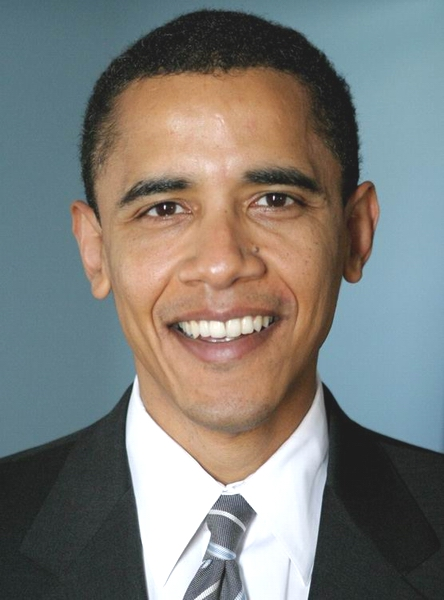

In [12]:
img = load("obama.jpg")

The Sobel kernel should operate on grayscale images, and we can use operator broadcasting to do that:

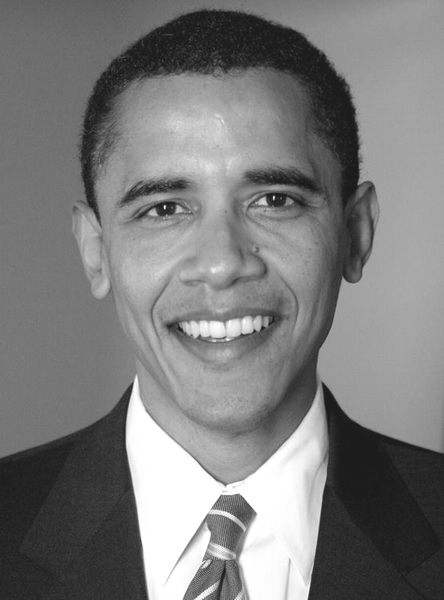

In [51]:
img_gray = Gray.(img)

## Sobel kernels

The first thing we'll try doing is manually running a Sobel image kernel on the input image. The [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) is basically an approximation of derivatives in the `X` and `Y` directions of the image. The theory is that if there is a high gradient magnitude, there is an edge in that location. The way you compute the Sobel operator is to convolve this kernel:

$$K_x = \begin{bmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{bmatrix}$$

in the `X` direction, and 

$$K_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$

in the `Y` direction. Note how they are just transposes of each other.

Practically, to compute the kernel, we need to iterate over the output image. As we discussed in [a previous post](http://learningjulia.com/2017/02/24/blurring-and-manipulation.html), when transforming one image into another, you need to iterate over the output image, and for each pixel, find the pixels from the input image needed to compute that particular pixel. In the case of the Sobel kernel, we need to iterate over the output twice - once for the `X` direction, which needs 9 pixels for the computation, and once for the `Y` direction computation, which also needs 9 pixels.

## The `imfilter` function

To apply image kernels, I am going to use the `imfilter` function from JuliaImages: http://juliaimages.github.io/latest/function_reference.html#ImageFiltering.imfilter. Rather than manually trying to implement out-of-bounds implementations or worrying about applying a dot product / convolution, let's just use the builtins.

Another awesome feature of the JuliaImages library is the ability to pad the input according to 4 rules:

1. _replicate_ - repeat the edge value until infinity
2. _circular_ - image edges "wrap around"
3. _symmetric_ - reflect relative to the required position
4. _reflect_ - reflect relative to the edge

Read more here: http://juliaimages.github.io/latest/function_reference.html#Boundaries-and-padding-1. Which you can specify by doing something like:

```
    imfilter(img, kernel, "replicate")
```

In my case, I will just use the "replicate" mode.

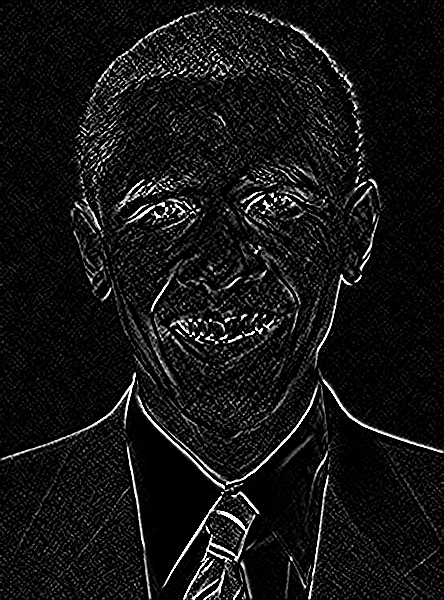

In [78]:
kernel = [1 0 -1; 2 0 -2;1 0 -1];
sobel_x = imfilter(img_gray, kernel);
grad = imfilter(sobel_x, kernel')

There are a few things to note about the `imfilter` function:

1. It doesn't do _convolution_. Instead, it does _correlation_. The difference is basically that in _convolution_ the kernel is flipped, so if you want to do convolution with `imfilter`, you should do `reflect()` around your kernel.
2. You need to assign a "center" to the kernels. Normally when we think of kernels we think of the center as being the central number in the kernel - in the Sobel kernels above the center is (1, 1). To do this in Julia, the default calling of `imfilter` will do this, or you can explicitly instantiate the a kernel by calling `centered()`:

    ```
    kernel = centered([1 0 -1; 2 0 -2;1 0 -1]);
    imfilter(img_gray, kernel)
    ```

    But in case you want a different center, you can use the [OffsetArrays](https://github.com/alsam/OffsetArrays.jl) package.
    
## Sobel to edges

What you can see from the image after the Sobel kernel is applied in the x and y directions is that there is a lot of noise all over the image - this is because the kernel is only looking at neighborhoods of 3x3. To get around this, we can just take the magnitude of the gradient, or even the 4th power of the gradient.

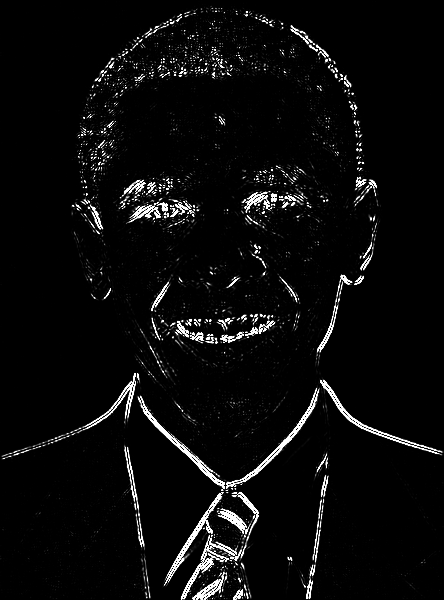

In [52]:
grad .^ 4

As you can see, much less noise.

## Separable kernels

However, using some interesting properties of the Sobel convolution operation, we can do even better. The Sobel kernel is separable - we can compute the full 3x3 kernel as a multiplication of a 1x3 and 3x1 kernels.

The kernels above ($K_x$ and $K_y$) can each be factored into two 1-dimensional kernels:

$$K_x = \begin{bmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{bmatrix} = \begin{bmatrix}1 \\ 2 \\ 1 \end{bmatrix} \cdot \begin{bmatrix}1 & 0 & -1 \end{bmatrix}$$

$$K_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix} = \begin{bmatrix}1 \\ 0 \\ -1 \end{bmatrix} \cdot \begin{bmatrix}1 & 2 & 1 \end{bmatrix}$$

So we can pass these 4 smaller kernels into `imfilter()` to get the same result:

In [80]:
kernel_1 = [1;2;1];
kernel_2 = [1 0 -1];
grad_sep = imfilter(img_gray, (kernel_1, kernel_2))

LoadError: DimensionMismatch("requested indices (2:193,434:447) and kernel indices (Base.OneTo(3),Base.OneTo(1)) do not agree with indices of padded input, (1:604,1:447)")

USE THIS: http://juliaimages.github.io/latest/imagefiltering.html#Factored-kernels-1 to factor kernels

There is one more way to apply Sobel kernels to the image. Of course, `imfilter()` has a Sobel kernel built in. and it's even separable

In [66]:
Kernel.sobel()

(
[-0.125 -0.25 -0.125; 0.0 0.0 0.0; 0.125 0.25 0.125],

[-0.125 0.0 0.125; -0.25 0.0 0.25; -0.125 0.0 0.125])